# Novelty
In this notebook, we will focus on the novelty aspect of the generated ligands. We will compare our compounds with two sets of compounds:
1. ChEMBL 33 compounds
2. Crystal Structure First Compounds

In [1]:
# imports
import pandas as pd
from rdkit.Chem import (AllChem, PandasTools)
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import HTML
from src.evaluation.utils import get_chembl_compounds_from_id, save_chemb_mcs_to_file
from pathlib import Path
PandasTools.RenderImagesInAllDataFrames(images=True)

## 1. ChEMBL 33 comparision
Since ChEMBL 33 comprises XXX componds, we perform the similarity comparision between our generated compounds and the ChEMBL compounds in a seperate script. To this end, the following steps need to be performed:
1. Download `chembl_33.sdf.gz` from [ChEMBL](https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_33/) and unpack it.
2. Run the ChEBML comparision script, e.g., with 
```bash
python3 src/evaluation/chembl/chembl_database_comp.py -p -o results_5n1f_25_02/5n1f/results_chembl.csv -c evaluation/chembl_33.sdf -l results_5n1f_25_02/5n1f/results.sdf
```
With that, we determine the most similar ChEMBL compound of each generated PKA ligand with a estimated binding affinity $\leq 1,000$ nM (`-p`).

**Note:** This script requires up to XXX GB RAM and takes about XXX min. The comparision results for the hamster PKA PDB `5n1f` are thus already available at `results_5n1f_25_02/5n1f/results_chembl.csv`. 

First, we load and prepare the precomputed comparision results:

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP,FP,GA,AP_smiles,FP_smiles,GA_smiles,most_similar_chembl_ligand.chembl_id,most_similar_chembl_ligand.similarity
0,,0.825466,133.57,2,"InChI=1S/C24H29N5/c1-23(2,3)19-6-4-17(5-7-19)1...",136,8,NaN,N#Cc1c[nH]c2ncccc12,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,CHEMBL603262,0.85
1,,1.738471,67.60,2,InChI=1S/C23H25ClN4/c1-2-26-22-27-14-11-21(28-...,420,7,NaN,CCNc1ncccn1,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,CHEMBL228133,0.72
2,,2.240375,29.01,2,InChI=1S/C23H20Cl2N4/c24-18-7-5-17(6-8-18)23(9...,8,7,NaN,Clc1c[nH]c2ncncc12,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,CHEMBL228133,0.71
3,,2.925760,124.80,2,InChI=1S/C18H19N5O2/c1-19-16-10-15-13(11-21-16...,327,348,NaN,CNc1cc2[nH]c(=O)ccc2cn1,CCC(=O)NCc1ccccn1,NaN,CHEMBL3883473,0.49
4,,3.619756,41.54,2,"InChI=1S/C21H29ClN4/c1-20(2,3)16-6-4-15(5-7-16...",220,8,NaN,Nc1ccc(Cl)cn1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,CHEMBL603262,0.63

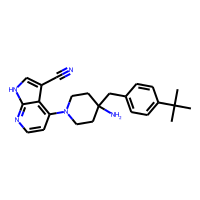
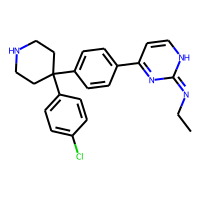
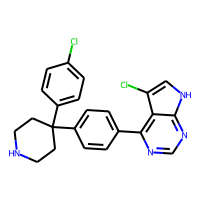
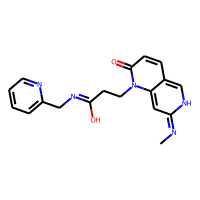
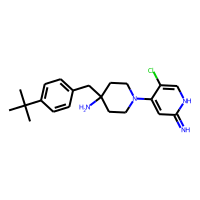

In [2]:
# read results
data_chembl = pd.read_csv("../results_5n1f_25_02/5n1f/results_chembl.csv", index_col=0).dropna(axis=1, how='all')
# generate mols from inchi
data_chembl['ROMol'] = data_chembl['inchi'].map(AllChem.MolFromInchi)
HTML(data_chembl.head().to_html(notebook=True))

Each compound is annotated with the ChEMBL ID of it's most similar ChEMBL compound (`most_similar_chembl_ligand.compound_id`) and the Tanimoto similarity to that ligand (`most_similar_chembl_ligand.similarity`).

We will first focus on the similairty values, and after, we will inspect some of these ChEMBL compounds themself.

### Similarity statistics and quantities
Let,s first look at the distibution of Tanimoto similarity values between the ligands and their respective most similar ChEMBL ligand.

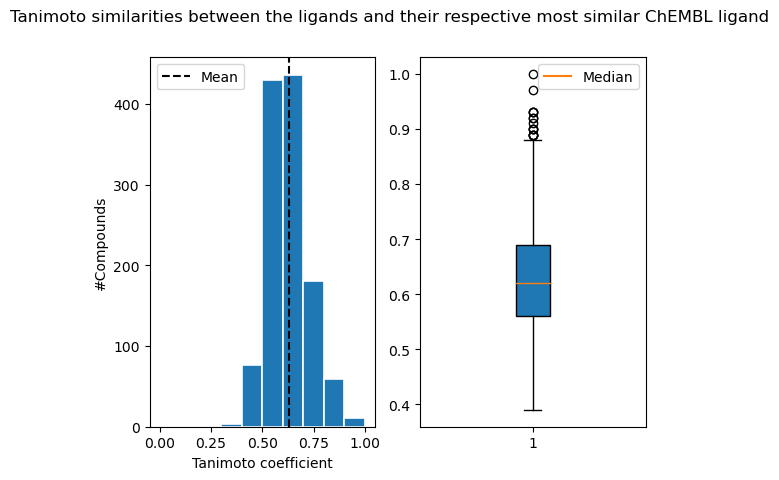

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2)

# Histogram of similarities
ax1.hist(
    data_chembl['most_similar_chembl_ligand.similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', 
    linewidth=1.2
)
ax1.set_xlabel('Tanimoto coefficient')
ax1.set_ylabel('#Compounds')
mean_line = ax1.axvline(data_chembl['most_similar_chembl_ligand.similarity'].mean(), color='k', linestyle='dashed', label="Mean")
ax1.legend(handles=[mean_line])

# Boxplot of similarities
boxplot = ax2.boxplot(data_chembl['most_similar_chembl_ligand.similarity'], patch_artist=True)
median_line = boxplot['medians'][0]
median_legend_handle, = ax2.plot([], [], color=median_line.get_color(), label="Median")
ax2.legend(handles=[median_legend_handle])

plt.suptitle("Tanimoto similarities between the ligands and their respective most similar ChEMBL ligand")
plt.show()

In [4]:
data_chembl['most_similar_chembl_ligand.similarity'].describe()

count    1196.000000
mean        0.630351
std         0.097345
min         0.390000
25%         0.560000
50%         0.620000
75%         0.690000
max         1.000000
Name: most_similar_chembl_ligand.similarity, dtype: float64

In [5]:
thresholds = [1, 0.95, 0.9, 0.85, 0.8]
print(f"Number of ligands with similarity of >= threshold to at least one ChEMBL compound:")
print(f"# Compounds\t| Threshold")
print(f"-----------\t|----------")
for threshold in thresholds:
    print(f"{threshold}\t\t| {sum(data_chembl['most_similar_chembl_ligand.similarity'] >= threshold)}")


Number of ligands with similarity of >= threshold to at least one ChEMBL compound:
# Compounds	| Threshold
-----------	|----------
1		| 1
0.95		| 2
0.9		| 11
0.85		| 29
0.8		| 70


We will now only consider the most similar ChEMBL compounds with a similarity of $\geq 0.9$ to the respective PKA compound:

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP,FP,GA,AP_smiles,FP_smiles,GA_smiles,most_similar_chembl_ligand.chembl_id,most_similar_chembl_ligand.similarity
0,,40.212366,7.57,2,"InChI=1S/C22H29N5/c1-21(2,3)17-6-4-16(5-7-17)1...",11,8,NaN,c1ncc2cc[nH]c2n1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,CHEMBL597211,1.00
1,,75.006211,8.46,2,"InChI=1S/C21H28N6/c1-20(2,3)16-6-4-15(5-7-16)1...",71,8,NaN,c1ncc2nc[nH]c2n1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,CHEMBL2420908,0.97
2,,151.416659,9.42,2,InChI=1S/C20H16O2/c1-14-13-18(11-12-19(14)21)1...,236,336,NaN,Cc1ccccc1O,O=C(c1ccccc1)c1ccccc1,NaN,CHEMBL1928176,0.93
3,,770.662310,-8.77,2,InChI=1S/C17H12N4/c18-7-2-4-12-3-1-5-13(9-12)1...,136,161,NaN,N#Cc1c[nH]c2ncccc12,N#CCCc1ccccc1,NaN,CHEMBL3959637,0.93
4,,844.463227,-3.24,2,"InChI=1S/C13H12N4O2S/c1-14-20(18,19)10-4-2-9(3...",11,291,NaN,c1ncc2cc[nH]c2n1,CNS(=O)(=O)c1ccccc1,NaN,CHEMBL4068933,0.93
5,,88.117491,150.37,2,InChI=1S/C24H32N4/c1-17-15-20-21(9-12-26-22(20...,299,8,NaN,Cc1cc2cccnc2[nH]1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,CHEMBL603262,0.92
6,,361.060900,-2.09,2,InChI=1S/C19H22FNO2/c1-13-10-17(6-7-19(13)22)2...,236,44,NaN,Cc1ccccc1O,OC[C@@H]1C[NH2+]CC[C@H]1c1ccc(F)cc1,NaN,CHEMBL254489,0.92
7,,548.652857,65.62,2,InChI=1S/C13H12N4O2/c1-18-8-3-4-10(19-2)9(5-8)...,71,442,NaN,c1ncc2nc[nH]c2n1,COc1ccc(OC)cc1,NaN,CHEMBL4974501,0.91
8,,180.750997,-19.87,2,InChI=1S/C20H18N4O2S/c25-19-14-4-3-13(9-12(14)...,334,406,NaN,O=c1[nH]ccc2ccccc12,O=c1[nH]c(C[NH+]2CCCC2)nc2ccsc12,NaN,CHEMBL4080367,0.90
9,,526.496902,21.34,2,InChI=1S/C18H15N3O/c22-18-14-11-20-21-17(14)13...,69,118,NaN,O=C1c2ccccc2-c2n[nH]cc21,NCCc1ccccc1,NaN,CHEMBL359180,0.90

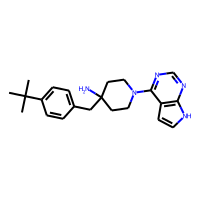
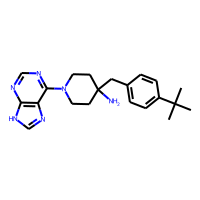
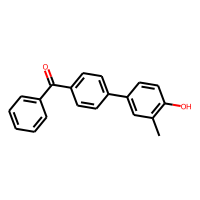
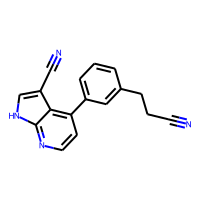
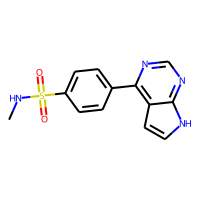
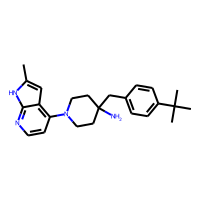
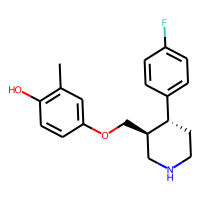
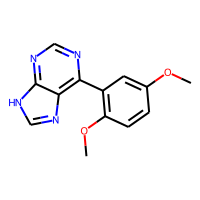
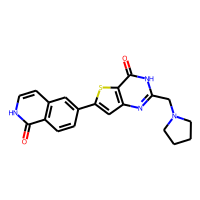
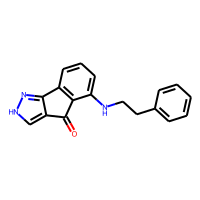
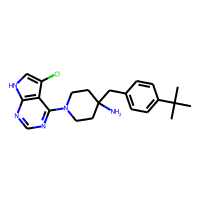

In [6]:
most_similar_pka_compounds = (data_chembl[data_chembl['most_similar_chembl_ligand.similarity'] >= 0.9]
                              .sort_values('most_similar_chembl_ligand.similarity', ascending=False)
                              .reset_index(drop=True))
HTML(most_similar_pka_compounds.to_html(notebook=True))

To inspect these ChEMBL compounds, we first need to get these compounds using their ID

  0%|          | 0/10 [00:00<?, ?it/s]

,chembl_id,ROMol,inchi
0,CHEMBL359180,,InChI=1S/C20H17N3O2/c1-3-12-7-9-13(10-8-12)18-...
1,CHEMBL254489,,InChI=1S/C18H20FNO/c19-16-8-6-14(7-9-16)18-10-...
2,CHEMBL597211,,"InChI=1S/C22H29N5/c1-21(2,3)17-6-4-16(5-7-17)1..."
3,CHEMBL603262,,"InChI=1S/C23H30N4/c1-22(2,3)18-6-4-17(5-7-18)1..."
4,CHEMBL1928176,,InChI=1S/C20H16O3/c1-13-11-16(9-10-19(13)22)14...
5,CHEMBL2420908,,InChI=1S/C17H20N6/c18-17(10-13-4-2-1-3-5-13)6-...
6,CHEMBL3959637,,InChI=1S/C16H13N3/c1-2-11-4-3-5-12(8-11)14-6-7...
7,CHEMBL4068933,,"InChI=1S/C12H10N4O2S/c13-19(17,18)9-3-1-8(2-4-..."
8,CHEMBL4080367,,InChI=1S/C16H16N4OS/c21-16-15-12(9-13(22-15)11...
9,CHEMBL4974501,,InChI=1S/C14H14N4O3/c1-19-9-5-4-8(12(20-2)13(9...

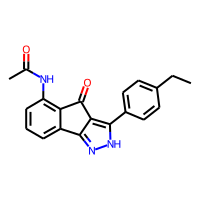
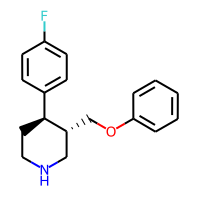
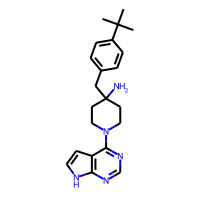
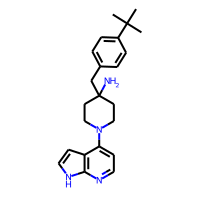
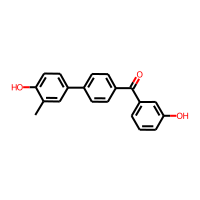
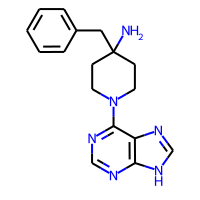
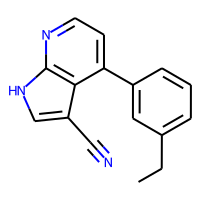
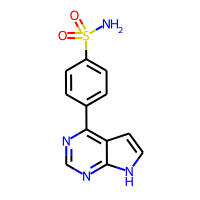
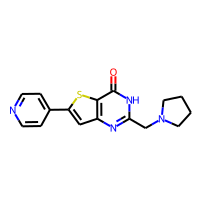
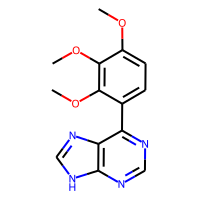

In [7]:
# get these compounds
most_similar_chembl_compounds = get_chembl_compounds_from_id(list(most_similar_pka_compounds['most_similar_chembl_ligand.chembl_id'].unique()))
HTML(most_similar_chembl_compounds.to_html(notebook=True))

We determine the MCS between a ChEMBL compounds (leftmost ligand) and the respective similar generated compounds and save it to PNG files within `results_5n1f_25_02/5n1f/chembl_mcs`.

In [8]:
save_chemb_mcs_to_file(most_similar_chembl_compounds, most_similar_pka_compounds, Path("../results_5n1f_25_02/5n1f/chembl_mcs"))

# Comparison to other kinase ligands

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP_smiles,FP_smiles,GA_smiles,AP_smiles_dummy,FP_smiles_dummy,GA_smiles_dummy,AP,FP,GA,most_similar.ligand_id,most_similar.similarity,least_similar.ligand_id,least_similar.similarity,mean_similarity
0,,0.825466,133.57,2,"InChI=1S/C24H29N5/c1-23(2,3)19-6-4-17(5-7-19)1...",N#Cc1c[nH]c2ncccc12,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,[4*]c1ccnc2[nH]cc(C#N)c12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,NaN,136,8,NaN,8ET,0.31,MPD,0.04,0.171892
1,,0.853035,300.13,3,InChI=1S/C24H27N5O2/c1-16-23-21(27-26-16)7-4-8...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,COCc1ccccc1,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[18*]c1cccc(COC)c1,297,51,114.0,7W8,0.26,MPD,0.03,0.132052
2,,1.037959,3151.95,3,"InChI=1S/C26H23ClN4O4S/c1-15-13-17(36(3,32)33)...",Nc1nccc2c(Cl)coc12,Cc1cc(S(C)(=O)=O)ccc1-c1nccn1C,OCc1ccccc1,[21*]c1cnc(N)c2oc([36*])c(Cl)c12,[28*]c1nc(-c2ccc(S(C)(=O)=O)cc2C)n(C)c1[39*],[10*]c1ccc(CO[24*])cc1,400,335,98.0,46P,0.22,MPD,0.02,0.128080
3,,1.509653,1481.09,3,InChI=1S/C22H21Cl2N5O/c1-13-21-19(27-26-13)3-2...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,Clc1ccccc1Cl,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[3*]c1ccc(Cl)c(Cl)c1,297,51,86.0,7W8,0.23,MPD,0.03,0.123645
4,,1.553260,7036.25,3,InChI=1S/C31H36FN3OS/c1-5-21-16-26(36)25(32)17...,c1cc2ccsc2cn1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,CCc1ccc(F)c(O)c1,[15*]c1c([24*])sc2cnccc12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,[31*]c1cc(F)c(O)cc1CC,49,8,85.0,7QL,0.26,MPD,0.03,0.137018

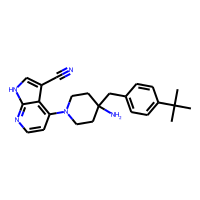
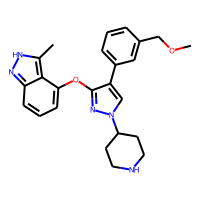
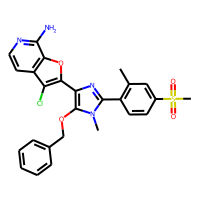
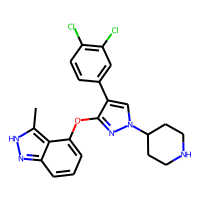
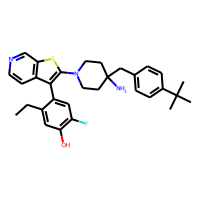

In [9]:
data_hamster_pka = pd.read_csv("hamster_pka_compare.csv", index_col=0).dropna(axis=1, how='all')
# generate mols from inchi
data_hamster_pka['ROMol'] = data_hamster_pka['inchi'].map(AllChem.MolFromInchi)
HTML(data_hamster_pka.head().to_html(notebook=True))

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP_smiles,FP_smiles,GA_smiles,AP_smiles_dummy,FP_smiles_dummy,GA_smiles_dummy,AP,FP,GA,most_similar.ligand_id,most_similar.similarity,least_similar.ligand_id,least_similar.similarity,mean_similarity
0,,0.825466,133.57,2,"InChI=1S/C24H29N5/c1-23(2,3)19-6-4-17(5-7-19)1...",N#Cc1c[nH]c2ncccc12,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,[4*]c1ccnc2[nH]cc(C#N)c12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,NaN,136,8,NaN,M05,0.62,ZN,0.0,0.183629
1,,0.853035,300.13,3,InChI=1S/C24H27N5O2/c1-16-23-21(27-26-16)7-4-8...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,COCc1ccccc1,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[18*]c1cccc(COC)c1,297,51,114.0,SS5,0.38,ZN,0.0,0.158138
2,,1.037959,3151.95,3,"InChI=1S/C26H23ClN4O4S/c1-15-13-17(36(3,32)33)...",Nc1nccc2c(Cl)coc12,Cc1cc(S(C)(=O)=O)ccc1-c1nccn1C,OCc1ccccc1,[21*]c1cnc(N)c2oc([36*])c(Cl)c12,[28*]c1nc(-c2ccc(S(C)(=O)=O)cc2C)n(C)c1[39*],[10*]c1ccc(CO[24*])cc1,400,335,98.0,G96,0.28,OCT,0.0,0.150108
3,,1.509653,1481.09,3,InChI=1S/C22H21Cl2N5O/c1-13-21-19(27-26-13)3-2...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,Clc1ccccc1Cl,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[3*]c1ccc(Cl)c(Cl)c1,297,51,86.0,SS5,0.36,ZN,0.0,0.151125
4,,1.553260,7036.25,3,InChI=1S/C31H36FN3OS/c1-5-21-16-26(36)25(32)17...,c1cc2ccsc2cn1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,CCc1ccc(F)c(O)c1,[15*]c1c([24*])sc2cnccc12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,[31*]c1cc(F)c(O)cc1CC,49,8,85.0,9D1,0.38,ZN,0.0,0.165122

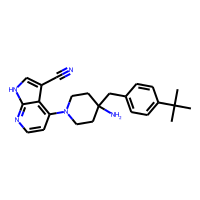
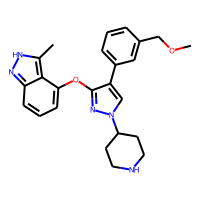
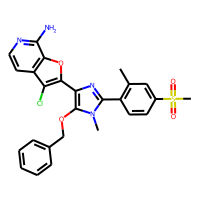
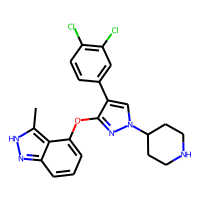
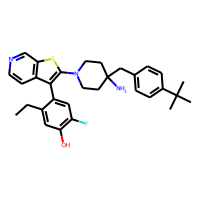

In [10]:
data_pka = pd.read_csv("pka_compare.csv", index_col=0).dropna(axis=1, how='all')
# generate mols from inchi
data_pka['ROMol'] = data_pka['inchi'].map(AllChem.MolFromInchi)
HTML(data_pka.head().to_html(notebook=True))

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP_smiles,FP_smiles,GA_smiles,AP_smiles_dummy,FP_smiles_dummy,GA_smiles_dummy,AP,FP,GA,most_similar.ligand_id,most_similar.similarity,least_similar.ligand_id,least_similar.similarity,mean_similarity
0,,0.825466,133.57,2,"InChI=1S/C24H29N5/c1-23(2,3)19-6-4-17(5-7-19)1...",N#Cc1c[nH]c2ncccc12,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,[4*]c1ccnc2[nH]cc(C#N)c12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,NaN,136,8,NaN,XFE,0.51,CA,0.0,0.169490
1,,0.853035,300.13,3,InChI=1S/C24H27N5O2/c1-16-23-21(27-26-16)7-4-8...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,COCc1ccccc1,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[18*]c1cccc(COC)c1,297,51,114.0,Q6W,0.47,CA,0.0,0.164276
2,,1.037959,3151.95,3,"InChI=1S/C26H23ClN4O4S/c1-15-13-17(36(3,32)33)...",Nc1nccc2c(Cl)coc12,Cc1cc(S(C)(=O)=O)ccc1-c1nccn1C,OCc1ccccc1,[21*]c1cnc(N)c2oc([36*])c(Cl)c12,[28*]c1nc(-c2ccc(S(C)(=O)=O)cc2C)n(C)c1[39*],[10*]c1ccc(CO[24*])cc1,400,335,98.0,GWH,0.35,CA,0.0,0.162258
3,,1.509653,1481.09,3,InChI=1S/C22H21Cl2N5O/c1-13-21-19(27-26-13)3-2...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,Clc1ccccc1Cl,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[3*]c1ccc(Cl)c(Cl)c1,297,51,86.0,2K0,0.47,CA,0.0,0.158815
4,,1.553260,7036.25,3,InChI=1S/C31H36FN3OS/c1-5-21-16-26(36)25(32)17...,c1cc2ccsc2cn1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,CCc1ccc(F)c(O)c1,[15*]c1c([24*])sc2cnccc12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,[31*]c1cc(F)c(O)cc1CC,49,8,85.0,29Z,0.39,CA,0.0,0.163399

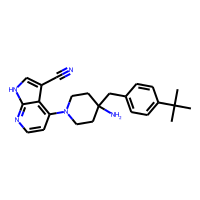
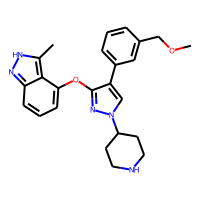
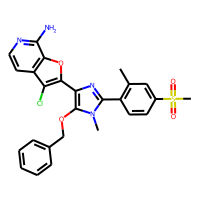
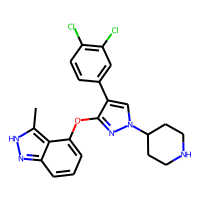
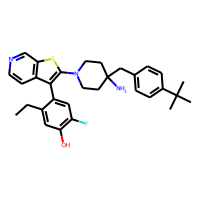

In [11]:
data_kinase = pd.read_csv("kinase_compare.csv", index_col=0).dropna(axis=1, how='all')
# generate mols from inchi
data_kinase['ROMol'] = data_kinase['inchi'].map(AllChem.MolFromInchi)
HTML(data_kinase.head().to_html(notebook=True))

In [12]:
data_hamster_pka[["most_similar.similarity", "least_similar.similarity", "mean_similarity"]].describe()

,most_similar.similarity,least_similar.similarity,mean_similarity
count,1166.000000,1166.000000,1166.000000
mean,0.280626,0.029142,0.134018
std,0.058414,0.013061,0.019751
min,0.170000,0.000000,0.089752
25%,0.240000,0.020000,0.120253
50%,0.270000,0.030000,0.132403
75%,0.310000,0.040000,0.145330
max,0.640000,0.070000,0.231153


,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP_smiles,FP_smiles,GA_smiles,AP_smiles_dummy,FP_smiles_dummy,GA_smiles_dummy,AP,FP,GA,most_similar.ligand_id,most_similar.similarity,least_similar.ligand_id,least_similar.similarity,mean_similarity
0,,560.113916,-21.26,2,InChI=1S/C20H20N2O3S/c23-20-19-6-5-17(13-18(19...,O=c1[nH]ccc2ccccc12,O=S1(=O)CC[NH+](Cc2ccccc2)CC1,NaN,[15*]c1ccc2c(=O)[nH]ccc2c1,[25*]c1ccc(C[NH+]2CCS(=O)(=O)CC2)cc1,NaN,334,301,NaN,7QW,0.64,MPD,0.02,0.179280
1,,144.856881,-16.75,2,"InChI=1S/C17H16N2O3S/c1-19(2)23(21,22)15-5-3-4...",O=c1[nH]ccc2ccccc12,CN(C)S(=O)(=O)c1ccccc1,NaN,[15*]c1ccc2c(=O)[nH]ccc2c1,[34*]c1cccc(S(=O)(=O)N(C)C)c1,NaN,334,450,NaN,P4W,0.62,MPD,0.02,0.231153
2,,757.729119,-20.25,2,InChI=1S/C23H23N3O3/c27-22-20-4-3-16(13-18(20)...,O=c1[nH]ccc2ccccc12,O=C1c2ccccc2CN1CC[NH+]1CCOCC1,NaN,[15*]c1ccc2c(=O)[nH]ccc2c1,[16*]c1ccc2c(c1)C(=O)N(CC[NH+]1CCOCC1)C2,NaN,334,217,NaN,7QW,0.61,MPD,0.03,0.180056
3,,770.277751,-19.31,2,InChI=1S/C20H19ClN2O3S/c21-19-12-18-16(5-6-22-...,O=c1[nH]ccc2ccc(Cl)cc12,O=S1(=O)CC[NH+](Cc2ccccc2)CC1,NaN,[17*]c1cc2cc[nH]c(=O)c2cc1Cl,[25*]c1ccc(C[NH+]2CCS(=O)(=O)CC2)cc1,NaN,295,301,NaN,7QW,0.57,MPD,0.02,0.171518
4,,704.104034,-18.77,2,InChI=1S/C23H22ClN3O3/c24-21-13-19-16(3-4-25-2...,O=c1[nH]ccc2ccc(Cl)cc12,O=C1c2ccccc2CN1CC[NH+]1CCOCC1,NaN,[17*]c1cc2cc[nH]c(=O)c2cc1Cl,[16*]c1ccc2c(c1)C(=O)N(CC[NH+]1CCOCC1)C2,NaN,295,217,NaN,7QW,0.54,MPD,0.03,0.173488

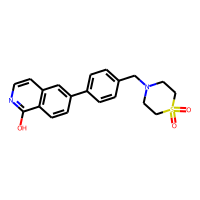
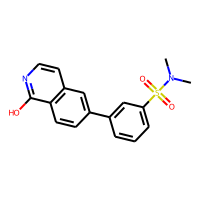
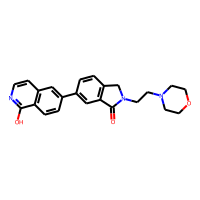
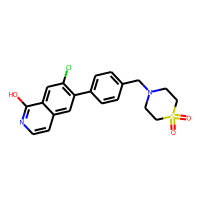
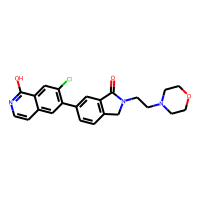

In [13]:
data_hamster_pka = data_hamster_pka.sort_values("most_similar.similarity", ascending=False, ignore_index=True)
HTML(data_hamster_pka.head().to_html(notebook=True))

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP_smiles,FP_smiles,GA_smiles,AP_smiles_dummy,FP_smiles_dummy,GA_smiles_dummy,AP,FP,GA,most_similar.ligand_id,most_similar.similarity,least_similar.ligand_id,least_similar.similarity,mean_similarity
0,,40.212366,7.57,2,"InChI=1S/C22H29N5/c1-21(2,3)17-6-4-16(5-7-17)1...",c1ncc2cc[nH]c2n1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,[18*]c1ncnc2[nH]ccc12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,NaN,11,8,NaN,M05,0.91,ZN,0.0,0.194713
1,,923.362957,29.42,2,"InChI=1S/C22H28ClN5/c1-21(2,3)16-6-4-15(5-7-16...",Clc1c[nH]c2ncncc12,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,[17*]c1ncnc2[nH]cc(Cl)c12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,NaN,8,8,NaN,M05,0.87,ZN,0.0,0.189054
2,,403.837545,188.95,2,InChI=1S/C17H14BrClN4OS/c18-15-2-1-14(25-15)16...,Nc1ncc2cc(Cl)ccc2n1,O=C(c1ccc(Br)s1)[C@@H]1CC[NH2+]C1,NaN,[16*]c1cc2nc(N[52*])ncc2cc1Cl,[35*][C@H]1C[NH2+]C[C@@H]1C(=O)c1ccc(Br)s1,NaN,140,389,NaN,4L7,0.82,ZN,0.0,0.159774
3,,380.011173,19.81,2,InChI=1S/C24H22ClN3/c25-22-8-6-21(7-9-22)24(11...,c1ccc2[nH]ncc2c1,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,[2*]c1ccc2[nH]ncc2c1,[37*]c1ccc(C2(c3ccc(Cl)cc3)CC[NH2+]CC2)cc1,NaN,43,7,NaN,GVP,0.77,ZN,0.0,0.165790
4,,122.251994,56.60,2,InChI=1S/C23H22ClNO/c24-21-9-7-20(8-10-21)23(1...,Oc1ccccc1,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,*c1ccc(O)cc1,[37*]c1ccc(C2(c3ccc(Cl)cc3)CC[NH2+]CC2)cc1,NaN,40,7,NaN,GVP,0.76,ZN,0.0,0.147922
5,,5.410153,8.11,2,InChI=1S/C23H21ClN4/c24-19-7-5-18(6-8-19)23(10...,c1ncc2cc[nH]c2n1,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,[18*]c1ncnc2[nH]ccc12,[37*]c1ccc(C2(c3ccc(Cl)cc3)CC[NH2+]CC2)cc1,NaN,11,7,NaN,GVK,0.76,ZN,0.0,0.183635
6,,55.078516,5.63,2,InChI=1S/C21H21ClN4/c22-18-7-5-17(6-8-18)21(10...,Nc1ncccn1,Clc1ccc(C2(c3ccccc3)CC[NH2+]CC2)cc1,NaN,[22*]Nc1nccc([33*])n1,[37*]c1ccc(C2(c3ccc(Cl)cc3)CC[NH2+]CC2)cc1,NaN,19,7,NaN,GVK,0.75,ZN,0.0,0.163927
7,,47.571315,-15.45,2,InChI=1S/C18H15BrN2O2S/c19-16-4-3-15(24-16)17(...,O=c1[nH]ccc2ccccc12,O=C(c1ccc(Br)s1)[C@@H]1CC[NH2+]C1,NaN,[15*]c1ccc2c(=O)[nH]ccc2c1,[35*][C@H]1C[NH2+]C[C@@H]1C(=O)c1ccc(Br)s1,NaN,334,389,NaN,4L7,0.75,ZN,0.0,0.153704
8,,75.006211,8.46,2,"InChI=1S/C21H28N6/c1-20(2,3)16-6-4-15(5-7-16)1...",c1ncc2nc[nH]c2n1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,NaN,[14*]c1ncnc2[nH]cnc12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,NaN,71,8,NaN,M02,0.74,ZN,0.0,0.201686
9,,785.129867,-13.97,2,InChI=1S/C18H16FN3O/c19-12-3-1-2-11(8-12)17(23...,c1cnc2[nH]ccc2c1,O=C(c1cccc(F)c1)[C@@H]1CC[NH2+]C1,NaN,[14*]c1ccnc2[nH]ccc12,[26*][C@H]1C[NH2+]C[C@@H]1C(=O)c1cccc(F)c1,NaN,17,390,NaN,8BQ,0.74,ZN,0.0,0.174276

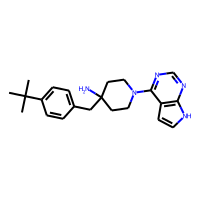
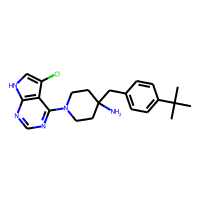
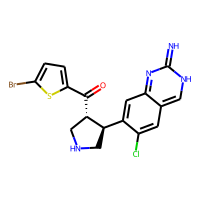
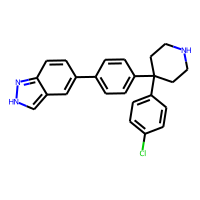
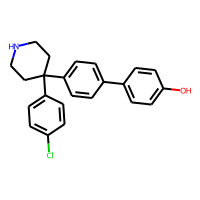
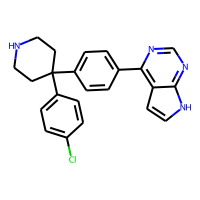
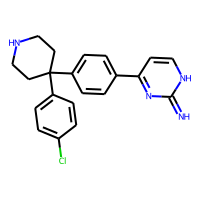
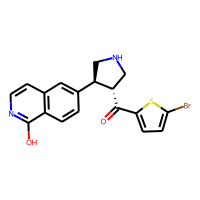
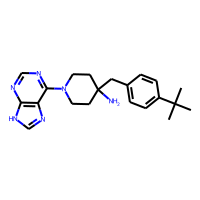
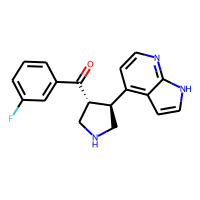

In [14]:
data_pka = data_pka.sort_values("most_similar.similarity", ascending=False, ignore_index=True)
HTML(data_pka.head(10).to_html(notebook=True))

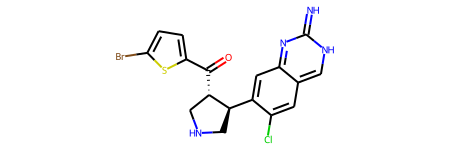

In [15]:
data_pka["ROMol"][2]

In [16]:
data_pka[["most_similar.similarity", "least_similar.similarity", "mean_similarity"]].describe()

,most_similar.similarity,least_similar.similarity,mean_similarity
count,1166.000000,1166.0,1166.000000
mean,0.375729,0.0,0.148514
std,0.100566,0.0,0.015596
min,0.220000,0.0,0.105701
25%,0.310000,0.0,0.136749
50%,0.360000,0.0,0.148331
75%,0.420000,0.0,0.159532
max,0.910000,0.0,0.201686


In [17]:
data_kinase[["most_similar.similarity", "least_similar.similarity", "mean_similarity"]].describe()

,most_similar.similarity,least_similar.similarity,mean_similarity
count,1166.000000,1166.0,1166.000000
mean,0.473250,0.0,0.146121
std,0.094284,0.0,0.016393
min,0.280000,0.0,0.084090
25%,0.410000,0.0,0.135249
50%,0.450000,0.0,0.146478
75%,0.520000,0.0,0.156868
max,0.890000,0.0,0.201891


Text(0, 0.5, '#Compounds')

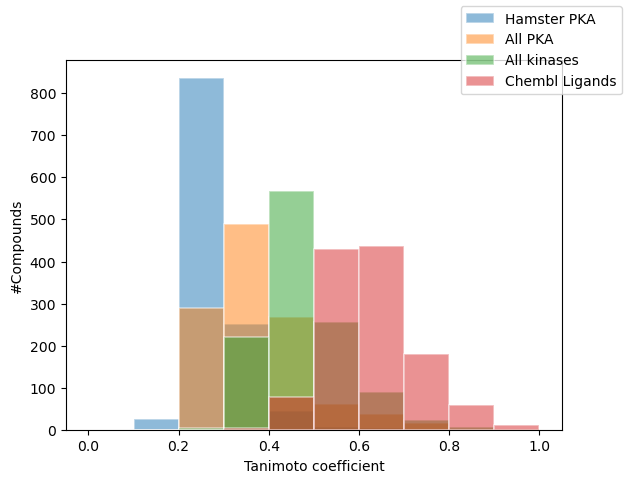

In [18]:
f, (ax1) = plt.subplots(1, 1)
ax1.hist(
    data_hamster_pka['most_similar.similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', alpha=0.5,
    linewidth=1.2, label="Hamster PKA"
)
ax1.hist(
    data_pka['most_similar.similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', alpha=0.5,
    linewidth=1.2, label="All PKA"
)
ax1.hist(
    data_kinase['most_similar.similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', 
    linewidth=1.2, alpha=0.5, label="All kinases"
)
ax1.hist(
    data_chembl['most_similar_chembl_ligand.similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', 
    linewidth=1.2, alpha=0.5, label="Chembl Ligands"
)
f.legend()
ax1.set_xlabel('Tanimoto coefficient')
ax1.set_ylabel('#Compounds')

Text(0, 0.5, '#Compounds')

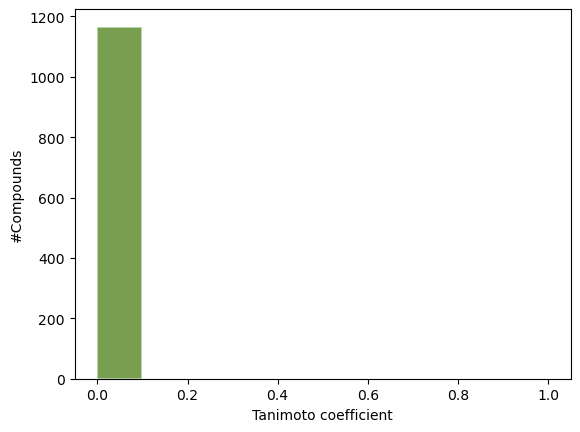

In [19]:
f, (ax1) = plt.subplots(1, 1)
ax1.hist(
    data_pka['least_similar.similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', alpha=0.5,
    linewidth=1.2
)
ax1.hist(
    data_hamster_pka['least_similar.similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', alpha=0.5,
    linewidth=1.2
)
ax1.hist(
    data_kinase['least_similar.similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', 
    linewidth=1.2, alpha=0.5
)
ax1.set_xlabel('Tanimoto coefficient')
ax1.set_ylabel('#Compounds')

Text(0, 0.5, '#Compounds')

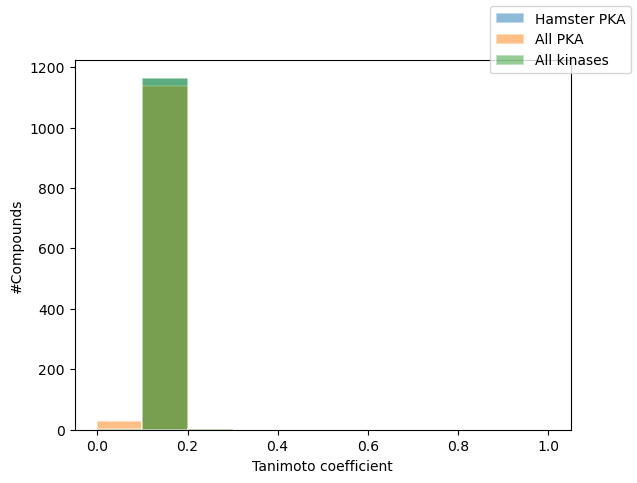

In [20]:
f, (ax1) = plt.subplots(1, 1)
ax1.hist(
    data_pka['mean_similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', alpha=0.5,
    linewidth=1.2, label="Hamster PKA"
)
ax1.hist(
    data_hamster_pka['mean_similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', alpha=0.5,
    linewidth=1.2, label="All PKA"
)
ax1.hist(
    data_kinase['mean_similarity'],
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', 
    linewidth=1.2, alpha=0.5, label="All kinases"
)
f.legend()
ax1.set_xlabel('Tanimoto coefficient')
ax1.set_ylabel('#Compounds')

* Kinase ligands: 58xx
* PKA: 334
* Hamster PKA: 119

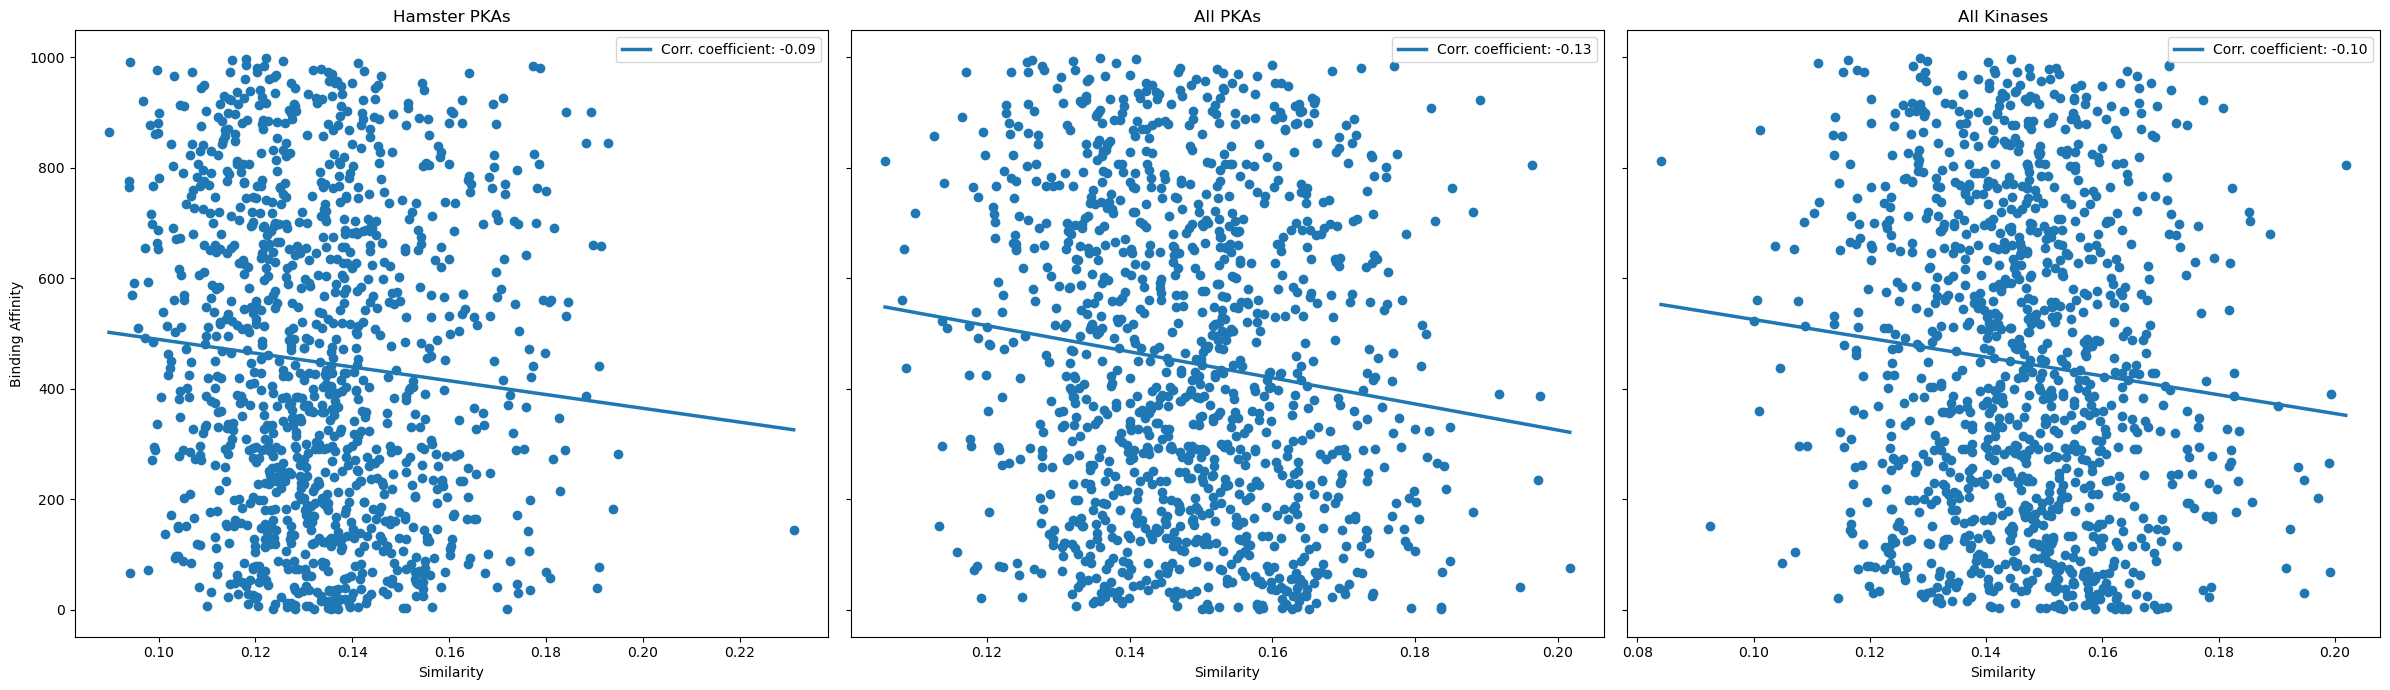

In [21]:
datasets = [
    ("Hamster PKAs", data_hamster_pka),
    ("All PKAs", data_pka),
    ("All Kinases", data_kinase)
]

fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)

for ax, (title, df) in zip(axes, datasets):
    ax.scatter(df['mean_similarity'], df['binding_affinity'])

    b, a = np.polyfit(df['mean_similarity'], df['binding_affinity'], 1)
    xseq = np.linspace(df['mean_similarity'].min(), df['mean_similarity'].max(), 100)
    ax.plot(xseq, a + b * xseq, lw=2.5, label=f"Corr. coefficient: {np.corrcoef(df['mean_similarity'], df['binding_affinity'])[0, 1]:.2f}")
    ax.legend()

    ax.set_title(title)
    ax.set_xlabel("Similarity")

axes[0].set_ylabel("Binding Affinity")

plt.tight_layout()
plt.show()

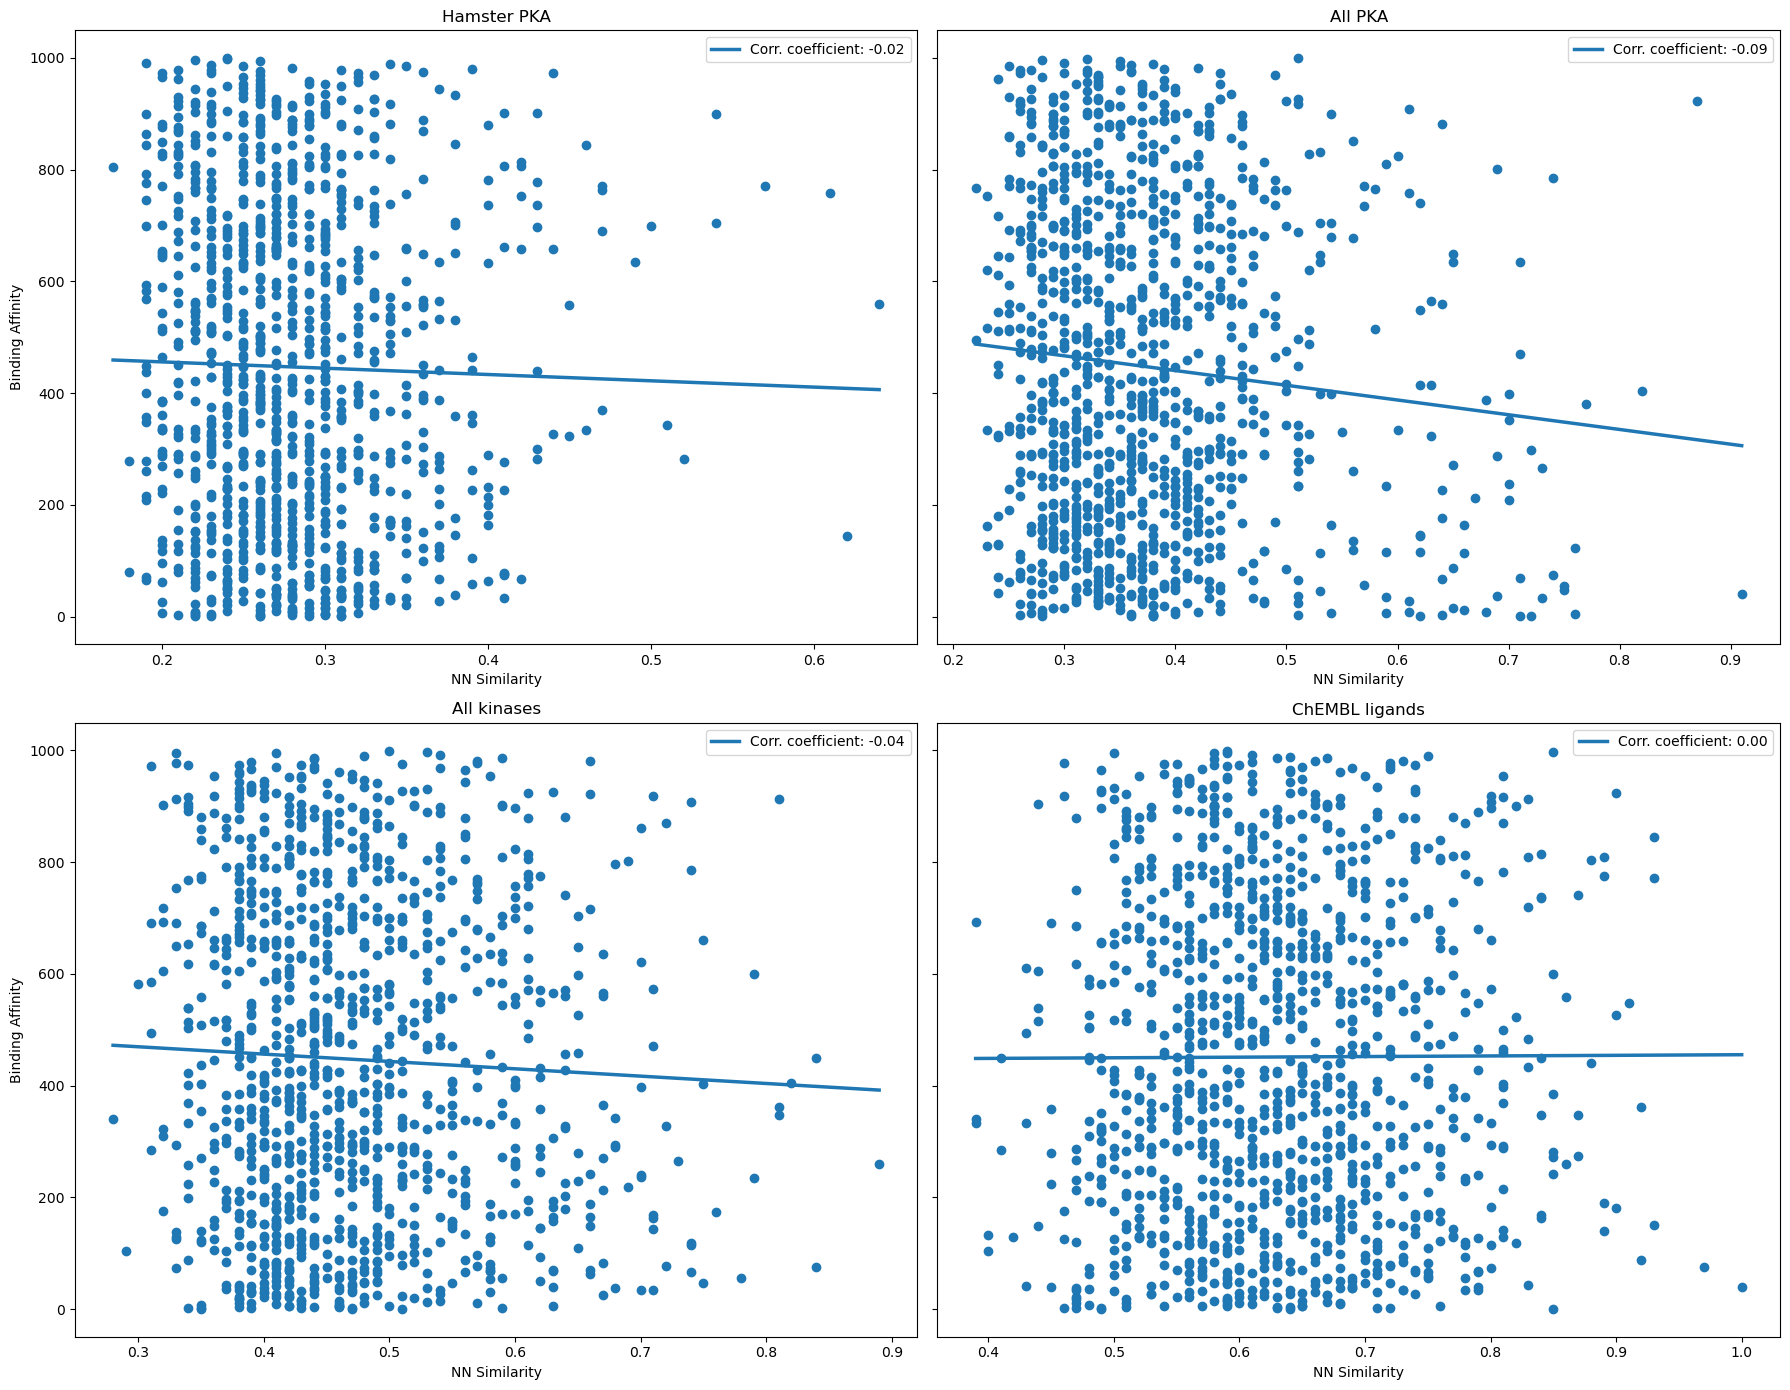

In [22]:
import matplotlib.pyplot as plt
import numpy as np

datasets = [
    ("Hamster PKA",  data_hamster_pka,  "most_similar.similarity"),
    ("All PKA",      data_pka,          "most_similar.similarity"),
    ("All kinases",  data_kinase,       "most_similar.similarity"),
    ("ChEMBL ligands", data_chembl,     "most_similar_chembl_ligand.similarity"),
]

fig, axes = plt.subplots(2, 2, figsize=(18, 14), sharey=True)
axes = axes.flatten()

for ax, (title, df, sim_col) in zip(axes, datasets):

    x = df[sim_col]
    y = df["binding_affinity"]

    ax.scatter(x, y)

    b, a = np.polyfit(x, y, 1)
    xseq = np.linspace(x.min(), x.max(), 100)
    ax.plot(xseq, a + b * xseq, lw=2.5, label=f"Corr. coefficient: {np.corrcoef(x, y)[0, 1]:.2f}")

    ax.set_title(title)
    ax.set_xlabel("NN Similarity")
    ax.legend()

axes[0].set_ylabel("Binding Affinity")
axes[2].set_ylabel("Binding Affinity")

plt.tight_layout()
plt.show()

,ROMol,binding_affinity,inchi,AP_smiles,FP_smiles,AP_smiles_dummy,FP_smiles_dummy,source,most_similar.ligand_id,most_similar.similarity,least_similar.ligand_id,least_similar.similarity,mean_similarity
4,,78.997832,InChI=1S/C17H12N6/c18-7-14-8-21-17-16(14)15(4-...,[4*]c1ccnc2[nH]cc(C#N)c12,c1ccc(Cn2cncn2)cc1,N#Cc1c[nH]c2ncccc12,[20*]c1cccc(Cn2cncn2)c1,proposed,7W8,0.41,MPD,0.01,0.140552
13,,199.645349,InChI=1S/C14H21N3O2/c15-14(18)12-3-1-4-13(11-1...,NaN,NaN,NaN,NaN,modified,463,0.39,MPD,0.06,0.150063
7,,159.018958,InChI=1S/C14H20FN3O2/c15-12-8-11(14(16)19)9-13...,[13*]NC(=O)c1cc([45*])cc(F)c1,NCCC[NH+]1CCOCC1,NC(=O)c1cccc(F)c1,[18*]NCCC[NH+]1CCOCC1,proposed,463,0.33,MPD,0.05,0.139727
9,,31.905653,InChI=1S/C16H13N5/c1-2-12(9-21-11-17-10-20-21)...,NaN,NaN,NaN,NaN,modified,7QW,0.32,MPD,0.01,0.143698
17,,361.238091,InChI=1S/C19H20N4O/c24-19(14-5-9-20-10-6-14)23...,NaN,NaN,NaN,NaN,modified,9NT,0.31,MPD,0.05,0.134889

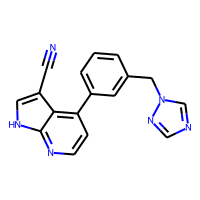
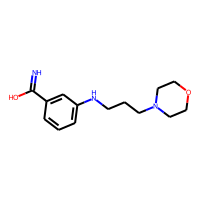
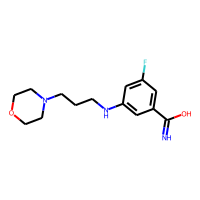
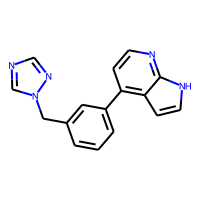
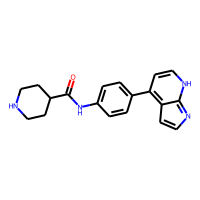

In [23]:
synthesized_h_pka = pd.read_csv("hamster_pka_compare_synth.csv", index_col=0).dropna(axis=1, how='all')
# generate mols from inchi
synthesized_h_pka['ROMol'] = synthesized_h_pka['inchi'].map(AllChem.MolFromInchi)
synthesized_h_pka = synthesized_h_pka.sort_values("most_similar.similarity", ascending=False)
HTML(synthesized_h_pka.head().to_html(notebook=True))

,ROMol,binding_affinity,inchi,AP_smiles,FP_smiles,AP_smiles_dummy,FP_smiles_dummy,source,most_similar.ligand_id,most_similar.similarity,least_similar.ligand_id,least_similar.similarity,mean_similarity
4,,78.997832,InChI=1S/C17H12N6/c18-7-14-8-21-17-16(14)15(4-...,[4*]c1ccnc2[nH]cc(C#N)c12,c1ccc(Cn2cncn2)cc1,N#Cc1c[nH]c2ncccc12,[20*]c1cccc(Cn2cncn2)c1,proposed,7W8,0.41,MPD,0.01,0.140552
7,,159.018958,InChI=1S/C14H20FN3O2/c15-12-8-11(14(16)19)9-13...,[13*]NC(=O)c1cc([45*])cc(F)c1,NCCC[NH+]1CCOCC1,NC(=O)c1cccc(F)c1,[18*]NCCC[NH+]1CCOCC1,proposed,463,0.33,MPD,0.05,0.139727
3,,37.431964,InChI=1S/C19H12ClN3O/c20-15-10-21-19-16(15)17(...,[17*]c1ncnc2[nH]cc(Cl)c12,O=C(c1ccccc1)c1ccccc1,Clc1c[nH]c2ncncc12,[43*]c1ccc(C(=O)c2ccccc2)cc1,proposed,7W8,0.28,MPD,0.01,0.141859
2,,36.463210,InChI=1S/C17H19ClN6/c18-14-7-12(20-8-11-3-5-19...,[14*]c1ncnc2[nH]cnc12,Clc1cccc(NCC2CC[NH2+]CC2)c1,c1ncc2nc[nH]c2n1,[32*]c1ccc(NCC2CC[NH2+]CC2)cc1Cl,proposed,ADE,0.28,MPD,0.04,0.131107
5,,121.451709,InChI=1S/C19H16ClN3O2/c20-16-10-22-18(21)9-14(...,[4*]Nc1cc([16*])c(Cl)cn1,O=C(Nc1ccccc1C[O-])c1ccccc1,Nc1ccc(Cl)cn1,[24*]c1ccc(C(=O)Nc2cccc([40*])c2C[O-])cc1,proposed,7W8,0.27,MPD,0.02,0.127436
6,,148.462302,InChI=1S/C19H20FN3O2/c20-15-10-14(18(21)24)11-...,[13*]NC(=O)c1cc([45*])cc(F)c1,O=C(Nc1ccccc1)C1CCNCC1,NC(=O)c1cccc(F)c1,[4*]N1CCC(C(=O)Nc2cccc([22*])c2)CC1,proposed,463,0.26,ISQ,0.04,0.124296
1,,20.672327,InChI=1S/C18H20ClN5/c19-16-9-13(22-10-12-3-6-2...,[18*]c1ncnc2[nH]ccc12,Clc1cccc(NCC2CC[NH2+]CC2)c1,c1ncc2cc[nH]c2n1,[32*]c1ccc(NCC2CC[NH2+]CC2)cc1Cl,proposed,7QR,0.24,MPD,0.05,0.119912
0,,11.141089,"InChI=1S/C19H18FNO4S2/c1-19(2,3)27(24,25)21-15...",[2*]c1cccc2sc(C(=O)[O-])cc12,CC(C)(C)S(=O)(=O)Nc1ccccc1F,O=C([O-])c1cc2ccccc2s1,[60*]c1ccc(F)c(NS(=O)(=O)C(C)(C)C)c1,proposed,7W8,0.22,MPD,0.03,0.114320

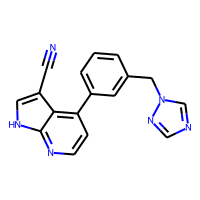
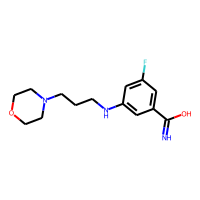
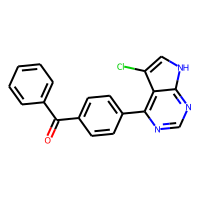
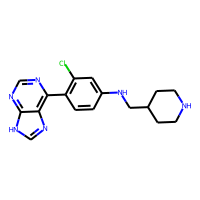
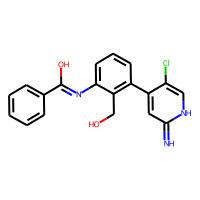
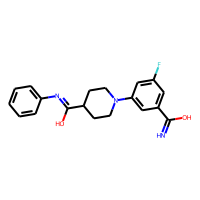
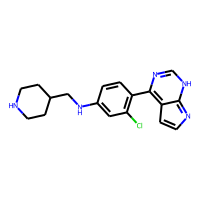
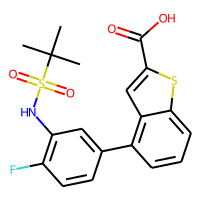

In [ ]:
HTML((synthesized_h_pka[synthesized_h_pka['source'] == "proposed"])[['ROMol', 'binding_affinity', "source",'most_similar.ligand_id', 'most_similar.similarity',	'mean_similarity']].to_html(notebook=True))

,ROMol,binding_affinity,source,most_similar.ligand_id,most_similar.similarity,mean_similarity
13,,199.645349,modified,463,0.39,0.150063
9,,31.905653,modified,7QW,0.32,0.143698
17,,361.238091,modified,9NT,0.31,0.134889
14,,208.611894,modified,463,0.30,0.130878
10,,87.090881,modified,7W8,0.29,0.148245
12,,192.351379,modified,7QF,0.29,0.130199
18,,476.206059,modified,9NT,0.28,0.157808
8,,21.723495,modified,9NT,0.28,0.130884
11,,131.506437,modified,9NT,0.26,0.128597
16,,321.315730,modified,T7W,0.24,0.119269

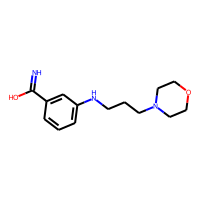
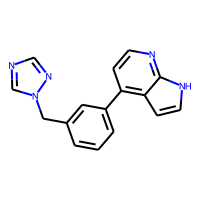
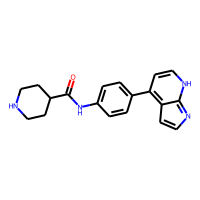
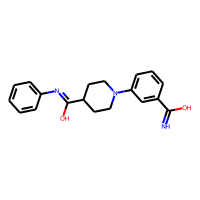
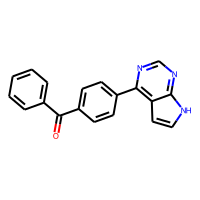
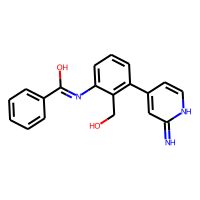
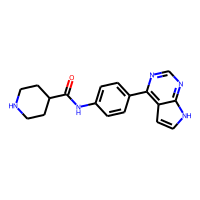
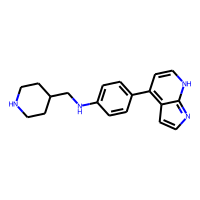
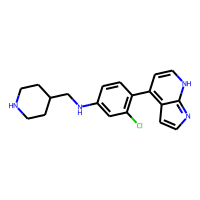
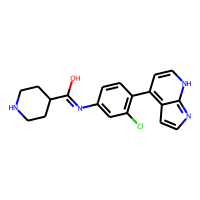
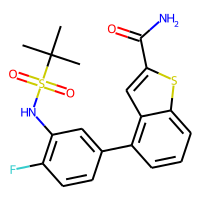
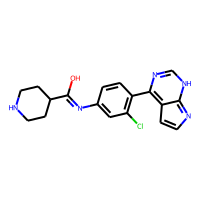

In [31]:
HTML((synthesized_h_pka[synthesized_h_pka['source'] == "modified"])[['ROMol', 'binding_affinity', "source",'most_similar.ligand_id', 'most_similar.similarity',	'mean_similarity']].to_html(notebook=True))

In [25]:
synthesized_h_pka[synthesized_h_pka['source'] == "proposed"].describe()

,binding_affinity,most_similar.similarity,least_similar.similarity,mean_similarity
count,8.000000,8.000000,8.000000,8.000000
mean,76.704924,0.286250,0.031250,0.129901
std,59.199763,0.059507,0.016421,0.010243
min,11.141089,0.220000,0.010000,0.114320
25%,32.515489,0.255000,0.017500,0.123200
50%,58.214898,0.275000,0.035000,0.129271
75%,128.204357,0.292500,0.042500,0.139934
max,159.018958,0.410000,0.050000,0.141859


In [26]:
synthesized_h_pka[synthesized_h_pka['source'] == "modified"].describe()

,binding_affinity,most_similar.similarity,least_similar.similarity,mean_similarity
count,12.000000,12.00000,12.000000,12.000000
mean,957.592797,0.28500,0.037500,0.133649
std,2589.061127,0.04462,0.016583,0.014016
min,21.723495,0.23000,0.010000,0.112493
25%,120.402548,0.25500,0.027500,0.126265
50%,204.128622,0.28500,0.040000,0.130881
75%,331.296320,0.30250,0.050000,0.144834
max,9167.716056,0.39000,0.060000,0.157808


,ROMol,binding_affinity,source,most_similar.ligand_id,most_similar.similarity,mean_similarity
18,,476.206059,modified,ZWG,0.64,0.179766
2,,36.463210,proposed,GVK,0.59,0.170108
10,,87.090881,modified,GVJ,0.57,0.162668
17,,361.238091,modified,ZWG,0.53,0.155097
3,,37.431964,proposed,GVJ,0.51,0.160077

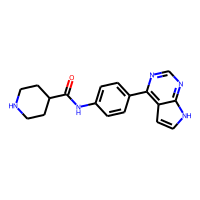
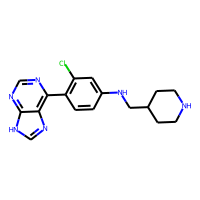
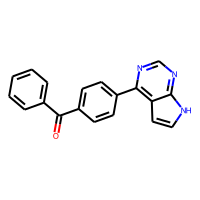
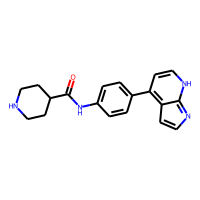
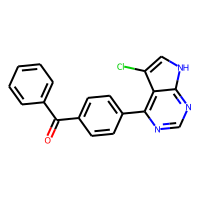

In [ ]:
synthesized_pka = pd.read_csv("pka_compare_synth.csv", index_col=0).dropna(axis=1, how='all')
# generate mols from inchi
synthesized_pka['ROMol'] = synthesized_pka['inchi'].map(AllChem.MolFromInchi)
synthesized_pka = synthesized_pka.sort_values("most_similar.similarity", ascending=False)
HTML(synthesized_pka[['ROMol', 'binding_affinity', "source",'most_similar.ligand_id', 'most_similar.similarity',	'mean_similarity']].head().to_html(notebook=True))